<a href="https://colab.research.google.com/github/rovle/prirucnik-za-prezivljavanje/blob/main/LUMEN_Evaluation_radionica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LUMEN Data Science Evaluation radionica

U ovoj radionici ćemo kratko demonstrirati kauzalnu inferenciju koristeći paket DoWhy.

Prvo instaliramo i importiramo potrebne pakete.

In [39]:
!pip install dowhy

from numpy.random import beta, uniform, binomial
from collections import defaultdict
import matplotlib.pyplot as plt
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
np.random.seed(42)

Definiramo naš dataset. Radi se o (izmaštanom) datasetu prodaje određenih proizvoda. Značajke su
- je li taj proizvod **šefov favorit**, binarno obilježje,
- je li taj proizvod **reklamiran**, binarno obilježje,
- **cijena** proizvoda, float od 10 do 1000,
- proporcija tih proizvoda koji su **oštećeni**, float od 0 do 1.
- je li taj proizvod **rasprodan**, binarno obilježje.

In [2]:
def generate_dataset_prodaje(koliko_utjece=0):
  sefov_favorit = binomial(1, 0.3, size=2000)
  
  reklamiran = beta(3, 5, size=2000) + sefov_favorit*0.2
  reklamiran = np.vectorize(round)(reklamiran)

  cijena = ( uniform(10, 800, size=2000)
              + 100*reklamiran
              + 100*sefov_favorit )

  osteceni = beta(2, 20, size=2000) + 0.1*(1 - cijena/1000)

  rasprodani = ( beta(2, 2, size=2000)
                + reklamiran*koliko_utjece
                - (cijena/1000)**3
                - osteceni*0.3 )
  rasprodani = np.vectorize(round)(rasprodani)
  rasprodani = np.clip(rasprodani, 0, 1)

  return reklamiran, cijena, osteceni, rasprodani, sefov_favorit

In [3]:
df = pd.DataFrame(np.transpose(generate_dataset_prodaje(0)), columns=["Reklamiran", "Cijena", "Osteceni", "Rasprodani",
                                                                        "Sefov_favorit"])

Kratko samo pregledavamo dataset:

In [4]:
df.describe()

,Reklamiran,Cijena,Osteceni,Rasprodani,Sefov_favorit
count,2000.00,2000.00,2000.00,2000.00,2000.00
mean,0.36,470.25,0.14,0.24,0.30
std,0.48,245.84,0.06,0.43,0.46
min,0.00,10.12,0.02,0.00,0.00
25%,0.00,266.03,0.10,0.00,0.00
50%,0.00,468.51,0.13,0.00,0.00
75%,1.00,670.93,0.18,0.00,1.00
max,1.00,998.90,0.43,1.00,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f211395ca90>,
      dtype=object)

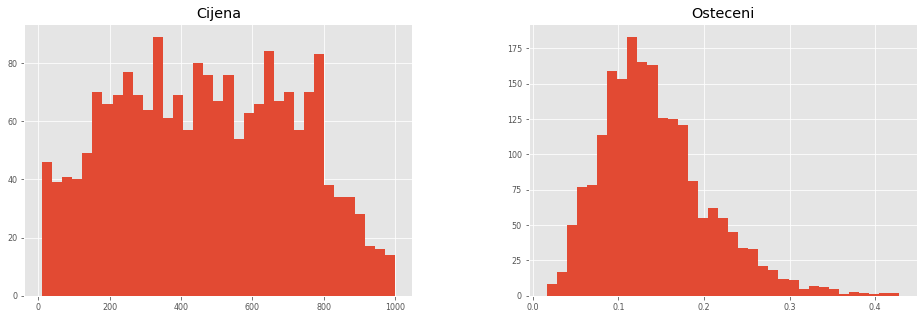

In [5]:
df[['Cijena', 'Osteceni']].hist(figsize=(16, 5), bins=35, xlabelsize=8, ylabelsize=8)

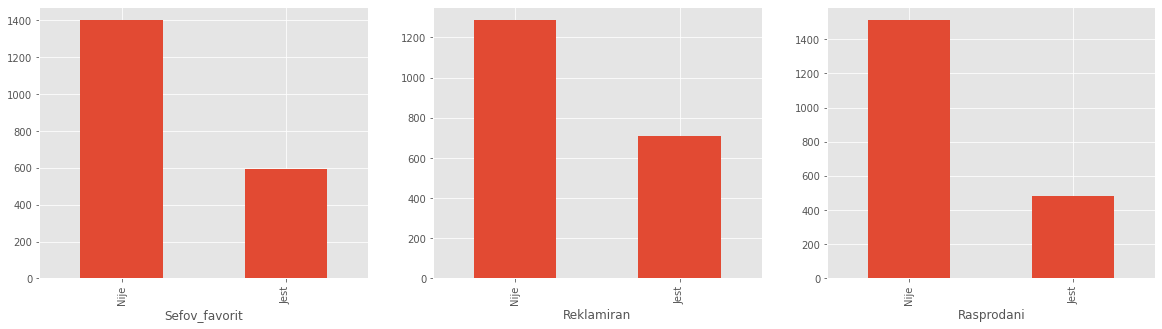

In [24]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

binarne_znacajke = ['Sefov_favorit', 'Reklamiran', 'Rasprodani']
for it, ix in enumerate(binarne_znacajke):
  df[[ix]].value_counts().plot.bar(ax=axes[it])
  axes[it].set_xticklabels(['Nije', 'Jest'])


Definiramo kauzalni graf:

In [9]:
causal_graph = """
digraph {
Reklamiran;
Cijena;
Osteceni;
Rasprodani;
Sefov_favorit;
Reklamiran -> Cijena; Cijena -> Osteceni;
Osteceni -> Rasprodani; Cijena -> Rasprodani;
Reklamiran->Rasprodani; Sefov_favorit -> Cijena;
Sefov_favorit -> Reklamiran;
}
"""

Definiramo kauzalni model i crtamo kauzalni graf:

In [10]:
df[['Reklamiran', 'Rasprodani']] = df[['Reklamiran', 'Rasprodani']].applymap(bool)

model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='Reklamiran',
        outcome='Rasprodani')

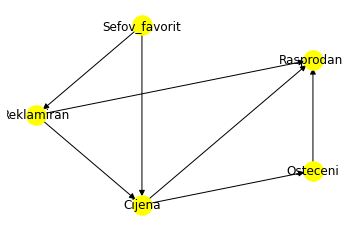

In [11]:
model.view_model()

Estimiramo kauzalni efekt:

In [29]:
estimands = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(estimands,method_name = "backdoor.linear_regression")
print(estimate.value)

-0.07123667677450779


## Refutacija

Ključan korak kauzalne inferencije su pokušaji refutacije onoga što smo dobili. Za to koristimo više tehnika:

### Random common cause

Dodajemo nezavisnu značajku kao zajednički uzrok značajkama dataseta; ako je kauzalna inferencija točna, estimacija se ne bi trebala značajno promijeniti.

In [13]:
refutel = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:-0.07305299634183735
New effect:-0.01952386024522915



### Placebo treatment

Zamijenimo treatment značajku (Reklamirani) s nekom slučajno značajkom; ako je kauzalna inferencija točna, estimacija bi trebala biti blizu nule.

In [14]:
refutel = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:-0.07305299634183735
New effect:-0.00200747857073064
p value:0.49



## Alexa play "All Together Now"

In [42]:
metode = ["backdoor.linear_regression",
          "backdoor.propensity_score_stratification"]

rezultati = defaultdict(list)

for znacajnost in np.arange(-0.1, 0.5, 0.01):
  for metoda in metode:
    df = pd.DataFrame(np.transpose(generate_dataset_prodaje(znacajnost)),
                      columns=["Reklamiran", "Cijena", "Osteceni",
                              "Rasprodani", "Sefov_favorit"])
    df[['Reklamiran', 'Rasprodani']] = df[['Reklamiran',
                                          'Rasprodani']].applymap(bool)

    model= CausalModel(
          data = df,
          graph=causal_graph.replace("\n", " "),
          treatment='Reklamiran',
          outcome='Rasprodani')
    
    estimands = model.identify_effect(proceed_when_unidentifiable=True)

    estimate = model.estimate_effect(estimands,
                                    method_name = metoda)
    

    rezultati[metoda].append((znacajnost, estimate.value))
  


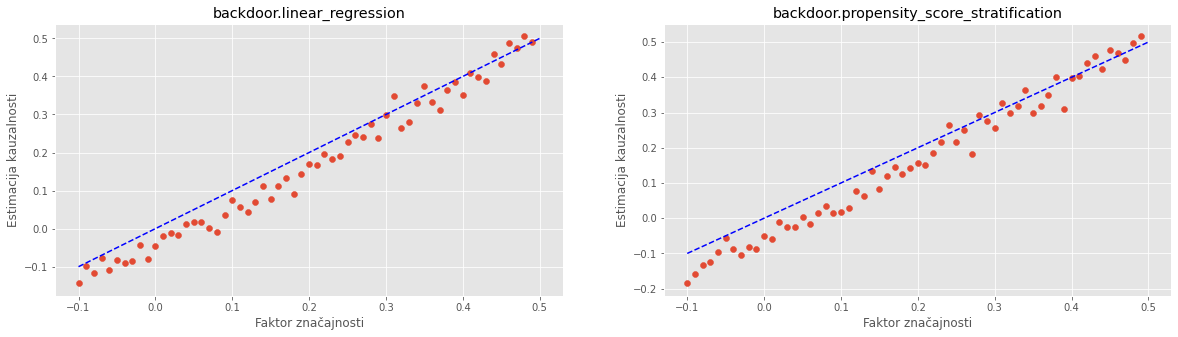

In [66]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20, 5)


for ix, metoda in enumerate(metode):
  tocke = rezultati[metoda]
  axes[ix].scatter(x = [p[0] for p in tocke],
                   y = [p[1] for p in tocke])
  axes[ix].plot(np.arange(-0.1, 0.6, 0.1),
                np.arange(-0.1, 0.6, 0.1),
                linestyle='--', color='blue')
  axes[ix].set_title(metoda)
  axes[ix].set_xlabel('Faktor značajnosti')
  axes[ix].set_ylabel('Estimacija kauzalnosti')